# Descarta de datos
Actualmente se estan descargando los datos del satelite **Sentinel-2**

**DATOS DE INTERES**

In [35]:
years =[2023, 2024] 
months = [1,2,3,4,5,6,7,8,9,10,11,12] 

**IMPORTACION DE LIBRERIAS**

In [36]:
import os
import ee 
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import geemap

In [37]:
current_date = datetime.date.today()

# Extraremos el año y mes 
current_year= current_date.year
current_month = current_date.month
print("Mes actual:", current_month)
print("Año actual:", current_year)

Mes actual: 12
Año actual: 2024


## Autentificación para GCP 

In [38]:
# 1) Obtención de la dirección de trabajo 
direction = os.getcwd()

# Remove the last part of the path
direction = os.path.dirname(direction)

# Dirección de la llave 
service_account= direction + '/conf/local/gcp-for-data-science-397913-4fd843feede1.json'

# Autentificación 
credentials = ee.ServiceAccountCredentials(email=None,key_file=service_account)
ee.Initialize(credentials)

## 1) Importación del área de interés 
**NOTA:** Se obtiene el área de interés por medio de un archivo tipo Geojson, kml o shape. Para este ejemplo se utilizará un KML. 

### 1.1) Carga y visualización con geopandas

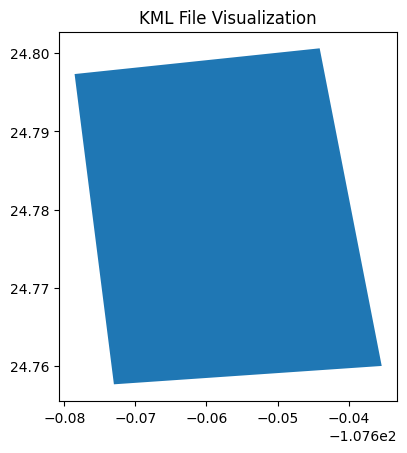

In [40]:
# Direction of the KML 
kml_file = direction + "/data/01_raw/Agricultura.kml"

# Nombre del archivo GeoJson a exportar 
geojson_file = direction + "/data/01_raw/Agricultura.geojson"

# 1) Lectura del kml 
gdf = gpd.read_file(filename=kml_file, driver="KML")

# 2) Exportación del kml a un Geo JSON 
gdf.to_file(filename=geojson_file, driver="GeoJSON")

# Plot using Geopandas
gdf.plot()

# Customize the plot
plt.title("KML File Visualization")
plt.show()

## 2) Descarga de imagenes satelitales
En esta sección se abordarán los siguientes procesos 

- **[Creación de un geometria para Earth Engine](https://developers.google.com/earth-engine/apidocs/ee-geometry)**: La geometria de earth engine se puede crear a partir de un GeoJSON, esto serivara para hacer el corte en las imagenes satelitales de interés
  
- Descarga de datos satelitales para esa área junto con un filtro al área de intrés, fechas y nubosidad 

### 2.1) Creación de una geometría de earth engine 
Para la creación de una geometría lo más indicado es convertir el KML en un archivo GeoJSON y este leerlo directamtne como geometría 

In [41]:
import json
# Step 1: Load the GeoJSON file

with open(geojson_file, "r") as f:
    geojson_data = json.load(f)

geojson_data["features"][0]["geometry"] # IMPORTANTE: Vease como contiene una tercera coordenada que es la altura (los valores de 0) , se deben de retirar 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008, 0.0],
   [-107.6353327971003, 24.76000824378666, 0.0],
   [-107.6440665193485, 24.80059938041618, 0.0],
   [-107.6785631858739, 24.79730942750482, 0.0],
   [-107.6730266244965, 24.75766085153008, 0.0]]]}

**Eliminación de la coordinada de elevación**

In [42]:
# Step 2: Function to remove the third dimension
def remove_third_dimension(geometry):
    """Removes the third dimension (z-values) from GeoJSON coordinates."""
    if geometry["type"] == "Polygon":
        geometry["coordinates"] = [
            [[coord[0], coord[1]] for coord in ring] for ring in geometry["coordinates"]
        ]
    elif geometry["type"] == "MultiPolygon":
        geometry["coordinates"] = [
            [[[coord[0], coord[1]] for coord in ring] for ring in polygon]
            for polygon in geometry["coordinates"]
        ]
    elif geometry["type"] == "LineString":
        geometry["coordinates"] = [[coord[0], coord[1]] for coord in geometry["coordinates"]]
    elif geometry["type"] == "Point":
        geometry["coordinates"] = geometry["coordinates"][:2]
    return geometry

# Step 3: Clean the geometry, ejecucón de la funcion 
cleaned_geometry = remove_third_dimension(geojson_data["features"][0]["geometry"])
cleaned_geometry # Vease ocmo aqui ya estan retirados la tercera dimensión de la altura 

{'type': 'Polygon',
 'coordinates': [[[-107.6730266244965, 24.75766085153008],
   [-107.6353327971003, 24.76000824378666],
   [-107.6440665193485, 24.80059938041618],
   [-107.6785631858739, 24.79730942750482],
   [-107.6730266244965, 24.75766085153008]]]}

**Convertir en geometría de Earth Engine**

In [43]:
# Step 4: Convert to Earth Engine Geometry
area_interest = ee.Geometry(cleaned_geometry)
type(area_interest)

ee.geometry.Geometry

### 2.2) Creación de un mapa base e integración de área de interés

**AÑADIMOS LA GEOMETRIA AL MAPA**

In [44]:
# 1) Creación del mapa base 
Map  = geemap.Map()

# Anadimos un base map distinto 
Map.add_basemap(basemap="Esri.WorldImagery")  # Imagene satelital de ESRI 

# 2) Add the geometry to the map
Map.addLayer(area_interest, {"color": "red"}, "Cleaned Geometry")

# Center the map on the geometry
Map.centerObject(area_interest, 11)

# Visualizacion del mapa en un broswer 
html_file = direction + "/data/02_intermediate/Map.html"
Map.to_html(filename=html_file, title="My Map", width="100%", height="880px") # Exporacion a una html 

### 2.3) Descarga de imagenes satelitales

**IMPORTANTE:** Se hará la descarga de las imagenes en los años que se eligieron al inicio 

In [47]:
# Definición del diccionario  de imagenes 
image_dic = {}  #Lista vacia 

for i in years:
    
    for z in months:
        
        #  Condicionante para pasar meses futuros 
        if i <= current_year and z <= current_month:
       
            # 1) Importación del image collection  de copernicus
            sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")
            
            # 2) Filtro por área de interés 
            sentinel2 = sentinel2.filterBounds(geometry=area_interest)
            
            #3) Filtro por fechas de interés 
            sentinel2  = sentinel2.filterDate(start=f"{i}-{z}-01", end=f"{i}-{z}-28") # año, mes y dia 
            
            # 4) Filtro por nubosidad 
            sentinel2 = sentinel2.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20)) # nubosidad menor al 
        
            # 5) Select the first cloud-free image de ese mes de ese año  que cumpla con el filtro 
            image = sentinel2.first()
            
            # 6) Recorte de la imagen 
            if image.getInfo() is not None:  # Validar que la imagen no sea null
                # Recorde de la imagen, usando la función de clip de ee https://developers.google.com/earth-engine/apidocs/ee-image-clip
                cropped_image = image.clip(area_interest)  # Recorta al área de interés
            
            # 7) Almacenar en el diccionario
                image_dic[f"{i}-{z}"] = cropped_image
                print(f"Solicitud de descarga en la fecha: {i}-{z}")
            else:
                print(f"No se encontró ninguna imagen válida para {i}-{z}")

Solicitud de descarga en la fecha: 2023-1
Solicitud de descarga en la fecha: 2023-2
Solicitud de descarga en la fecha: 2023-3
Solicitud de descarga en la fecha: 2023-4
Solicitud de descarga en la fecha: 2023-5
Solicitud de descarga en la fecha: 2023-6
Solicitud de descarga en la fecha: 2023-7
Solicitud de descarga en la fecha: 2023-8
Solicitud de descarga en la fecha: 2023-9
Solicitud de descarga en la fecha: 2023-10
Solicitud de descarga en la fecha: 2023-11
Solicitud de descarga en la fecha: 2023-12
Solicitud de descarga en la fecha: 2024-1
Solicitud de descarga en la fecha: 2024-2
Solicitud de descarga en la fecha: 2024-3
Solicitud de descarga en la fecha: 2024-4
Solicitud de descarga en la fecha: 2024-5
Solicitud de descarga en la fecha: 2024-6
Solicitud de descarga en la fecha: 2024-7
Solicitud de descarga en la fecha: 2024-8
Solicitud de descarga en la fecha: 2024-9
Solicitud de descarga en la fecha: 2024-10
Solicitud de descarga en la fecha: 2024-11
Solicitud de descarga en la f

In [49]:
image

## 3) Exportación 
La exportación la realizaremos a un bucket de GCP
 
API Reference: https://developers.google.com/earth-engine/apidocs/export-image-tocloudstorage#colab-python

In [48]:
## AQUI !!! 
